# `importing libearies and reading data `

In [100]:
import random
import statistics
import numpy as np
from scipy.signal import butter, filtfilt,sosfilt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pywt
import math
import pandas as pd
from utils import *

In [101]:
normal_train_path="Normal&LBBB/Normal_Train.txt"
normal_test_path = "Normal&LBBB/Normal_Test.txt"
lbbb_train_path = "Normal&LBBB/LBBB_Train.txt"
lbbb_test_path = "Normal&LBBB/LBBB_Test.txt"

In [102]:
FS=360
LOW_CUT=0.5
HIGH_CUT=40

In [103]:
normal_train=getDataEntries(normal_train_path)
normal_test = getDataEntries(normal_test_path)
lbbb_train=getDataEntries(lbbb_train_path)
lbbb_test=getDataEntries(lbbb_test_path)

data_train = normal_train + lbbb_train
data_test = normal_test + lbbb_test

d:\Mazen\Collage\DSP\DSP-Project\utils.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


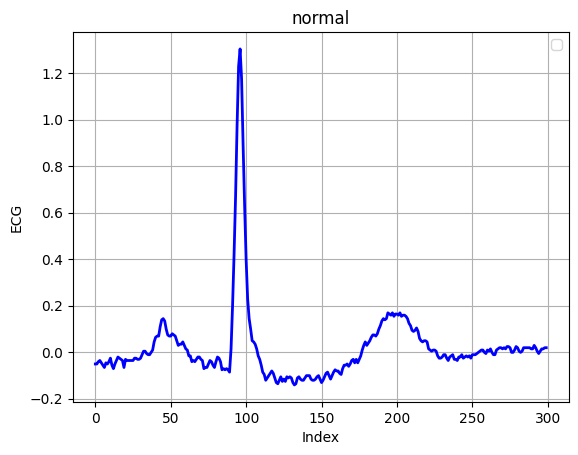

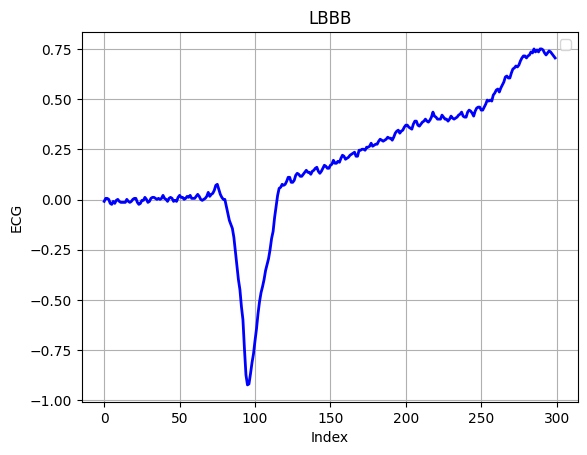

In [104]:
plot(normal_train[0],"normal")
plot(lbbb_train[0],"LBBB")

# `data preprocessing`

## removing mean

In [105]:
normal_train=remove_mean_for_all(normal_train)
normal_test=remove_mean_for_all(normal_test)
lbbb_test=remove_mean_for_all(lbbb_test)
lbbb_train=remove_mean_for_all(lbbb_train)

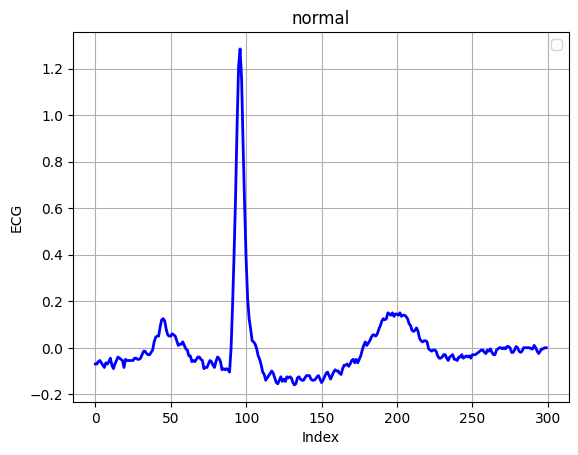

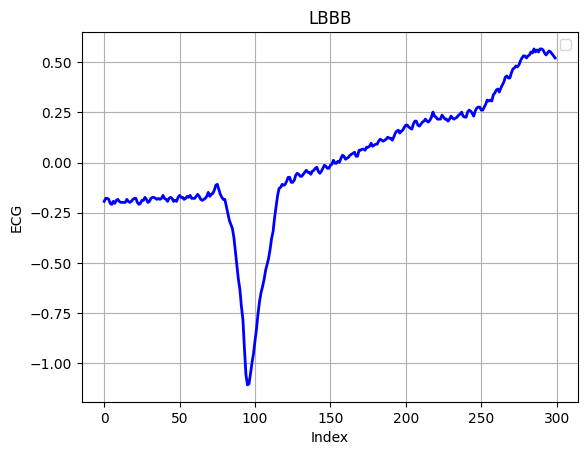

In [106]:
plot(normal_train[0],"normal")
plot(lbbb_train[0],"LBBB")

## applying bandbass filtter

In [107]:
normal_train=apply_bandpass_filter_batch(normal_train,FS)
normal_test=apply_bandpass_filter_batch(normal_test,FS)
lbbb_test=apply_bandpass_filter_batch(lbbb_test,FS)
lbbb_train=apply_bandpass_filter_batch(lbbb_train,FS)

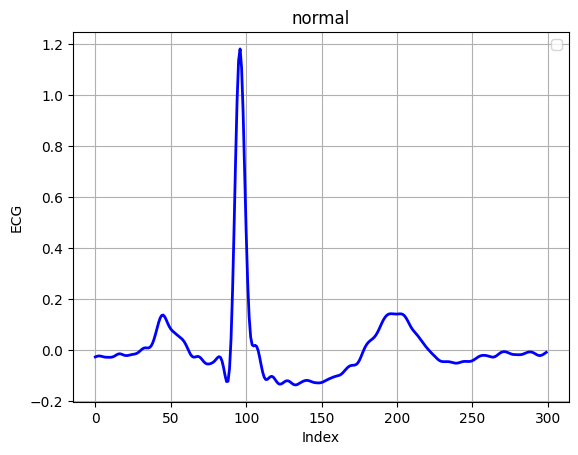

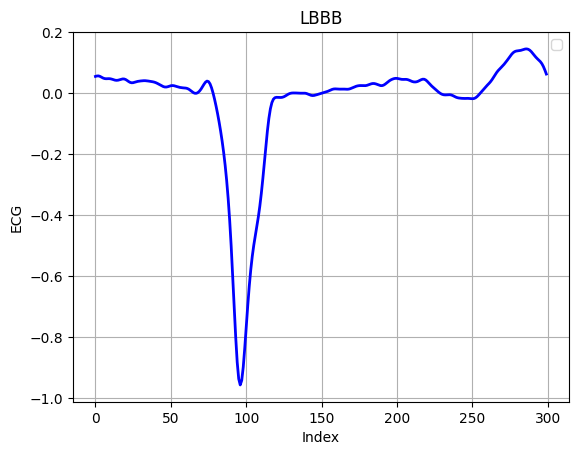

In [108]:
plot(normal_train[0],"normal")
plot(lbbb_train[0],"LBBB")

## normalizing the data

In [109]:
normal_train=normalize_for_all(normal_train)
normal_test=normalize_for_all(normal_test)
lbbb_test=normalize_for_all(lbbb_test)
lbbb_train=normalize_for_all(lbbb_train)

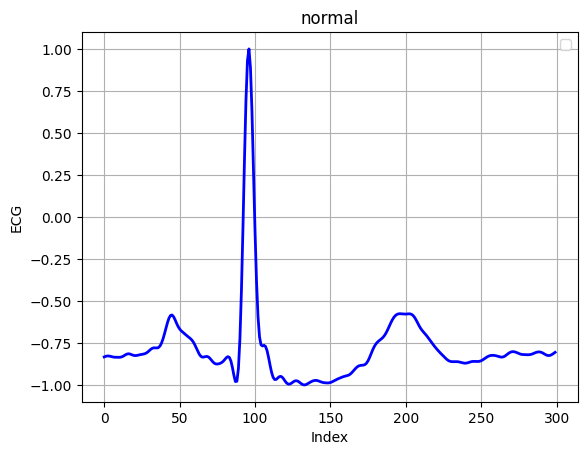

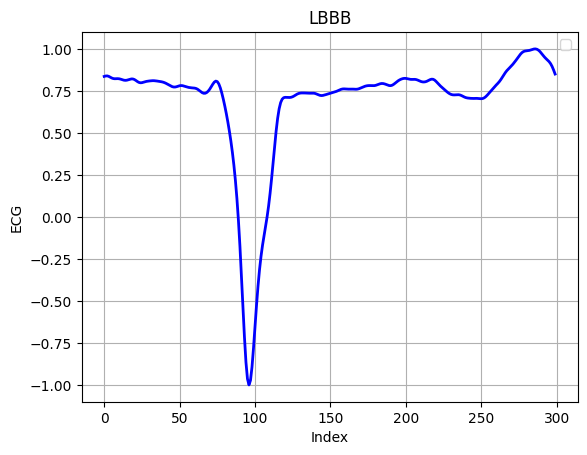

In [110]:
plot(normal_train[0],"normal")
plot(lbbb_train[0],"LBBB")

# Wavelet

In [111]:
train= normal_train+lbbb_train
test=normal_test+lbbb_test
y_train=[0]*len(normal_train)+[1]*len(lbbb_train)
y_test=[0]*len(normal_test)+[1]*len(lbbb_test)

Detecting the best combination:

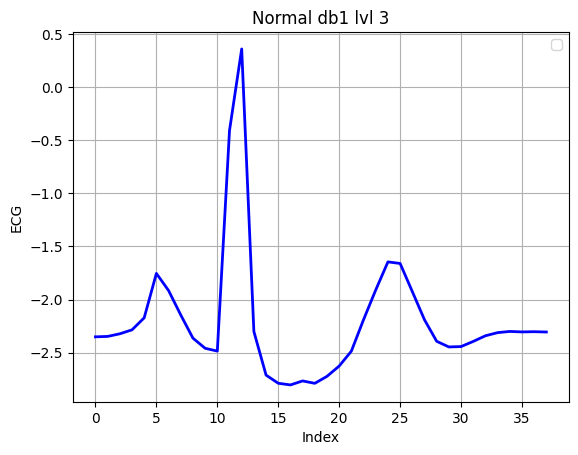

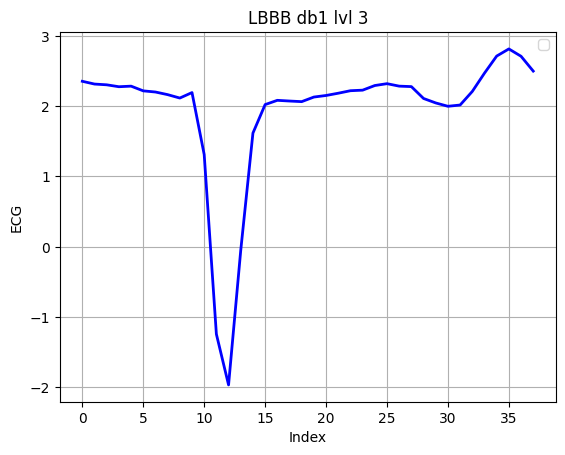

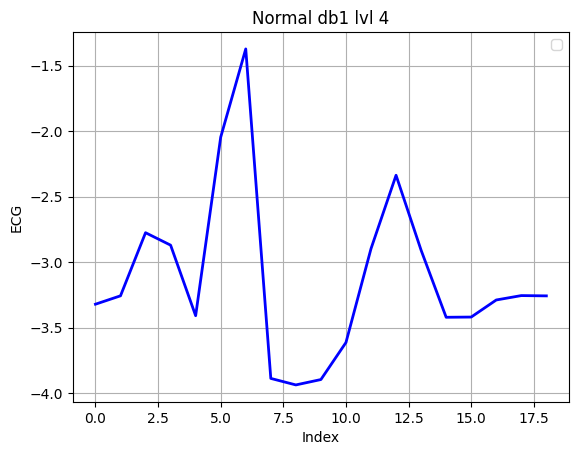

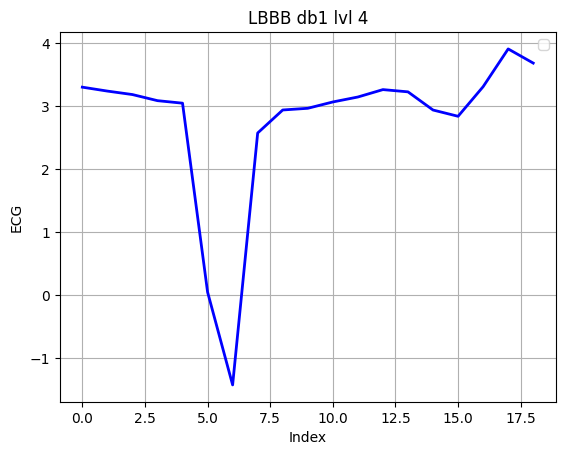

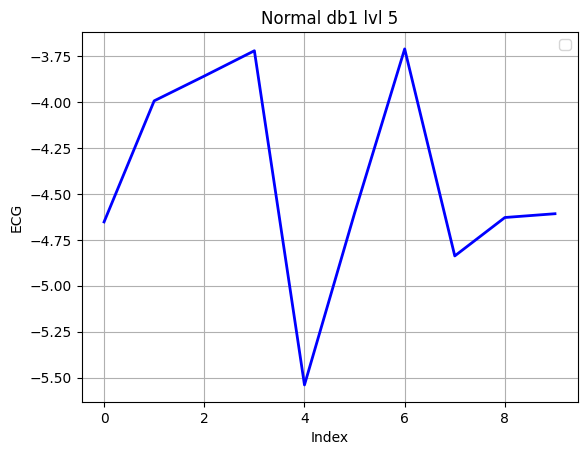

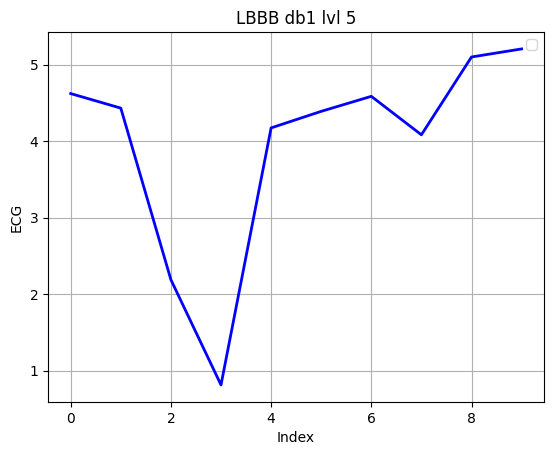

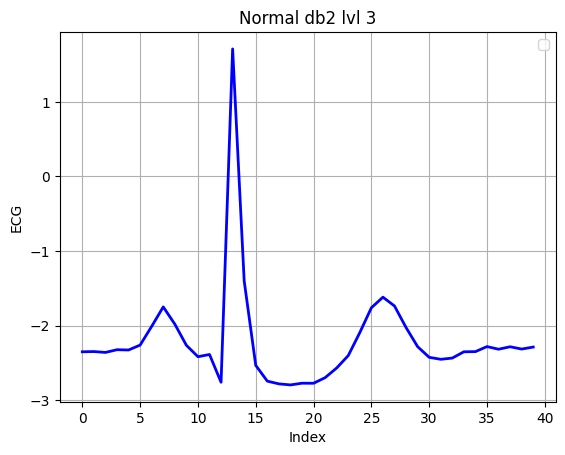

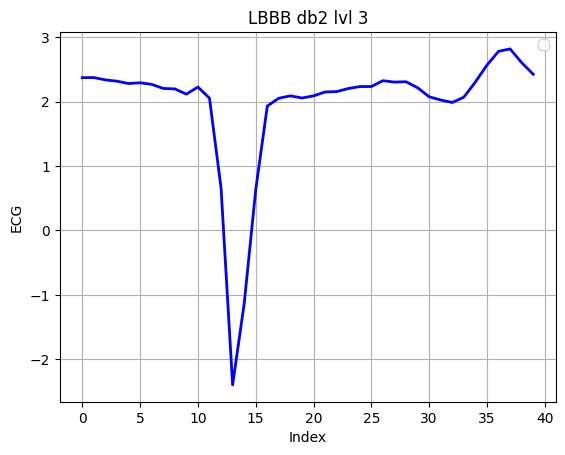

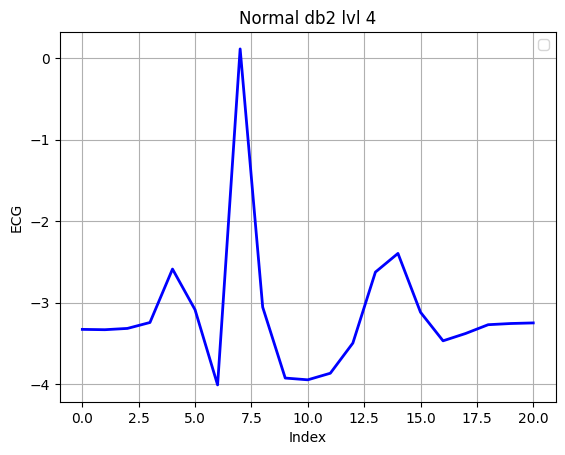

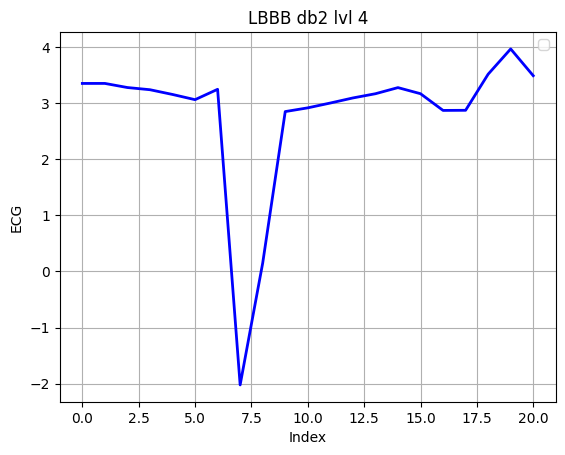

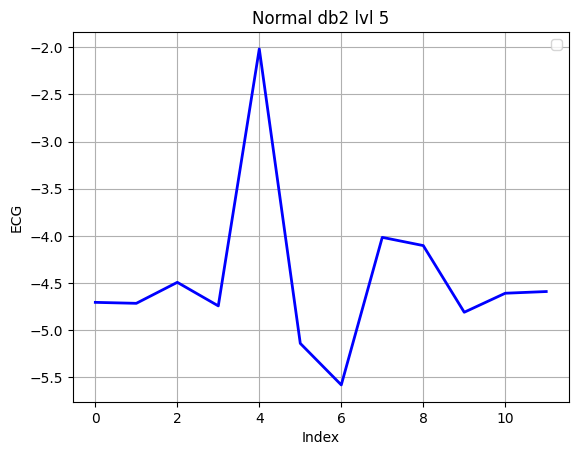

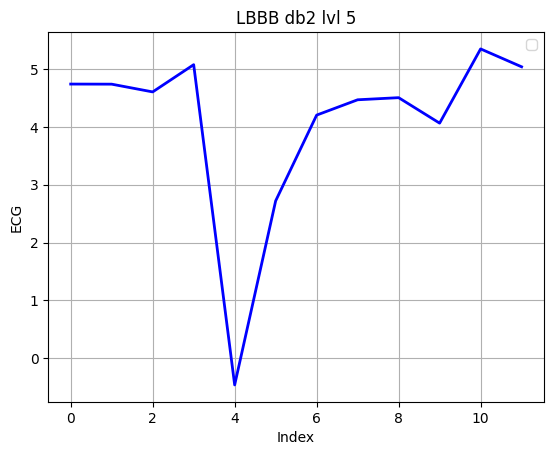

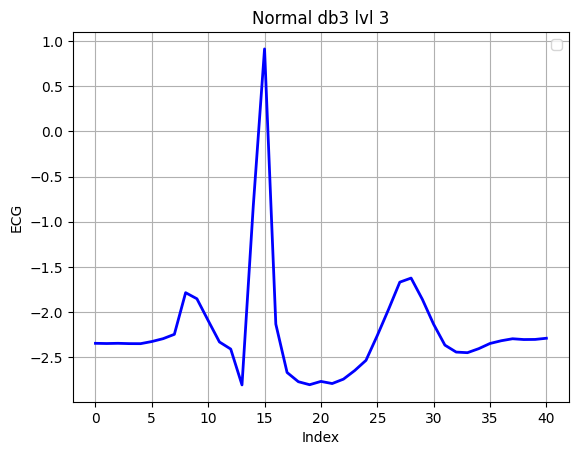

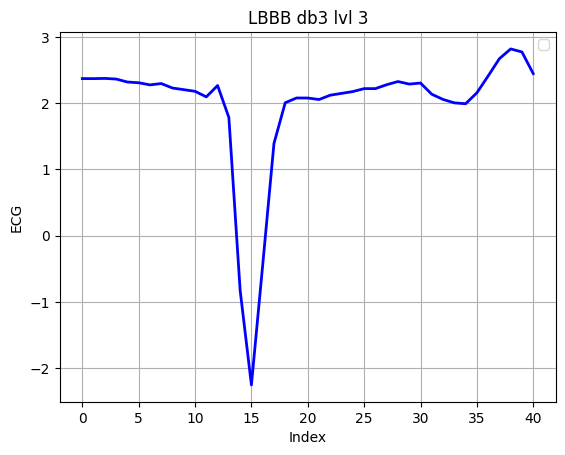

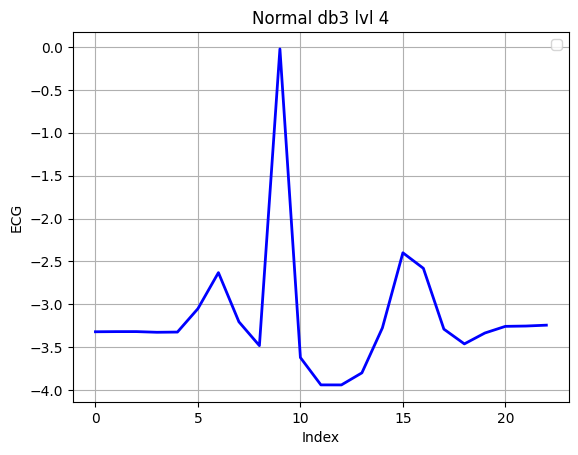

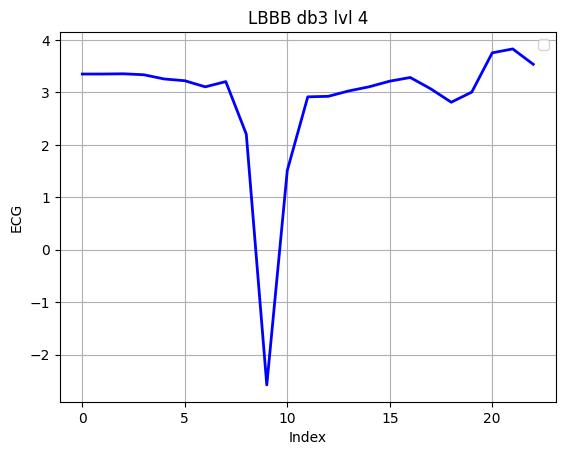

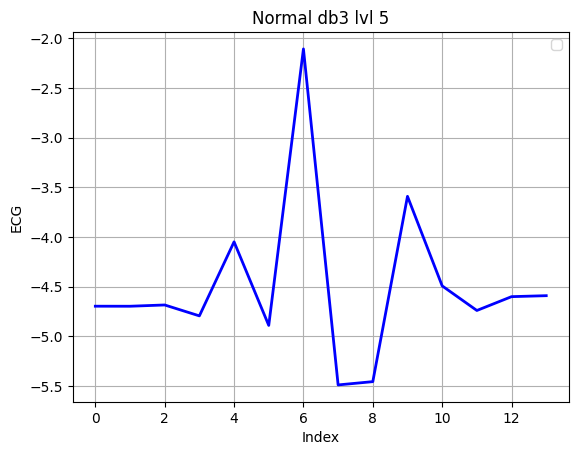

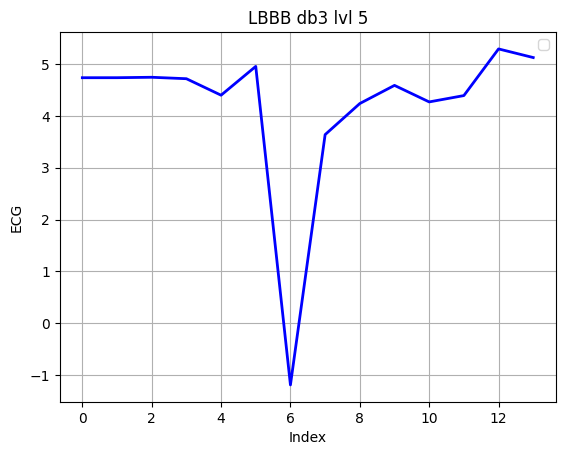

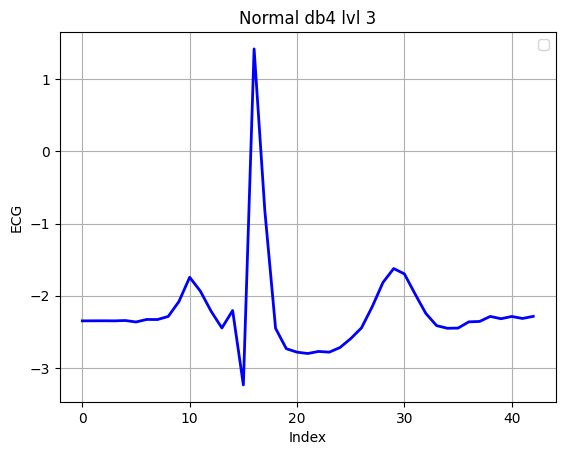

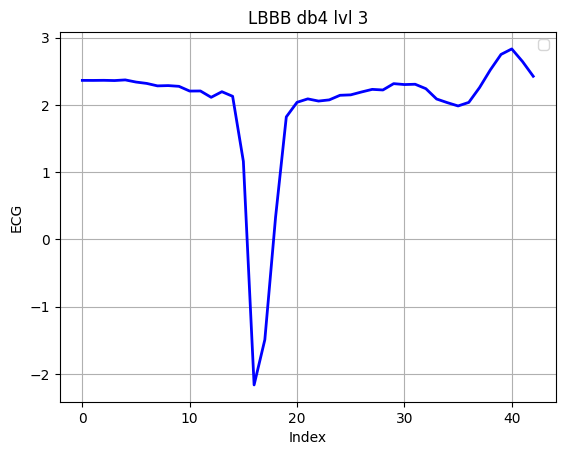

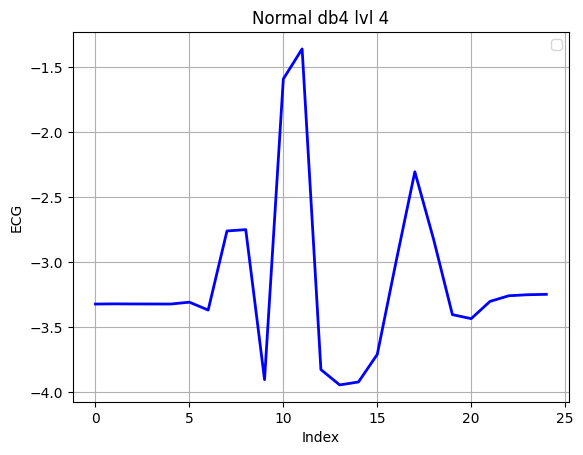

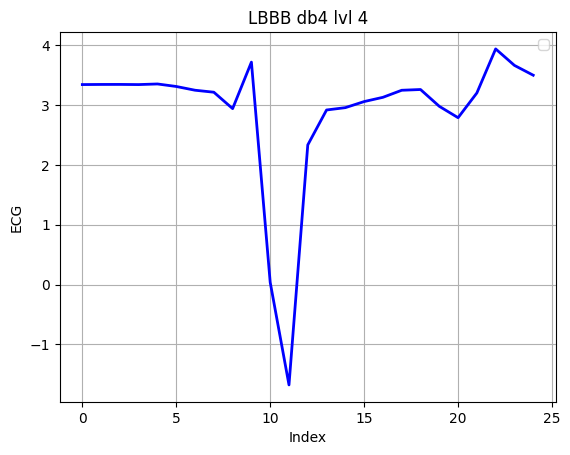

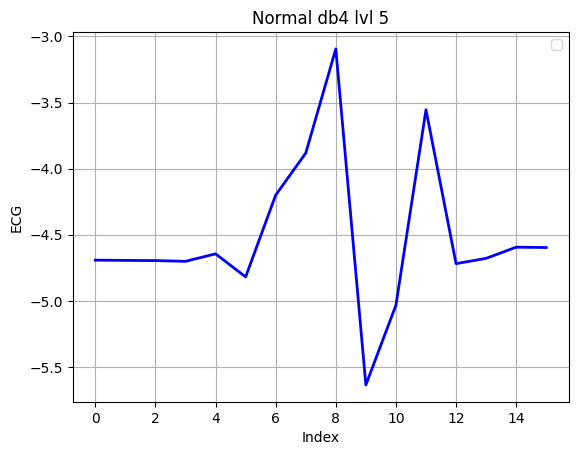

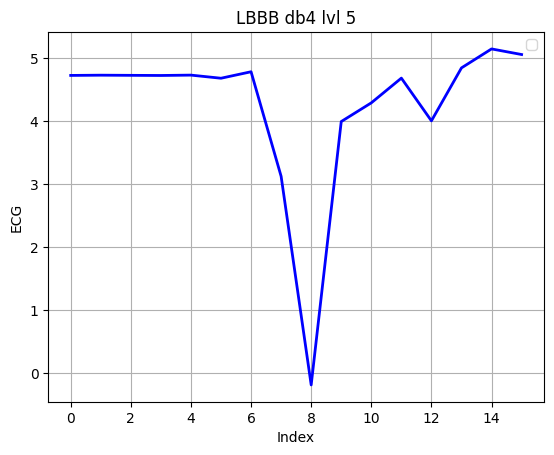

In [112]:
for i in range(1, 5):
    for j in range(3, 6):
        WAVELET_FAMILY = 'db' + str(i)
        LEVEL = j
        normal_coeff=pywt.wavedec(train[0],wavelet=WAVELET_FAMILY,level=LEVEL)
        plot(normal_coeff[0],"Normal " + WAVELET_FAMILY + " lvl " + str(LEVEL))
        LBBB_coeff=pywt.wavedec(train[len(normal_train)],wavelet=WAVELET_FAMILY,level=LEVEL)
        plot(LBBB_coeff[0],"LBBB " + WAVELET_FAMILY + " lvl " + str(LEVEL))


For normal signal: the best combinations is ['db2' with level 3, 'db2' with level 4]

For LBBB signal: the best combinations is ['db2' with level 4, 'db2' with level 5]

## applying wavelet

In [113]:
WAVELET_FAMILY='db2'
LEVEL = 3
train_app=[]
test_app=[]

In [114]:
for i in range(len(train)):
    train_coeff=pywt.wavedec(train[i],wavelet=WAVELET_FAMILY,level=LEVEL)
    app=train_coeff[0]
    train_app.append(app)
    
for i in range(len(test)):
    test_coeff=pywt.wavedec(test[i],wavelet=WAVELET_FAMILY,level=LEVEL)
    app=test_coeff[0]
    test_app.append(app)

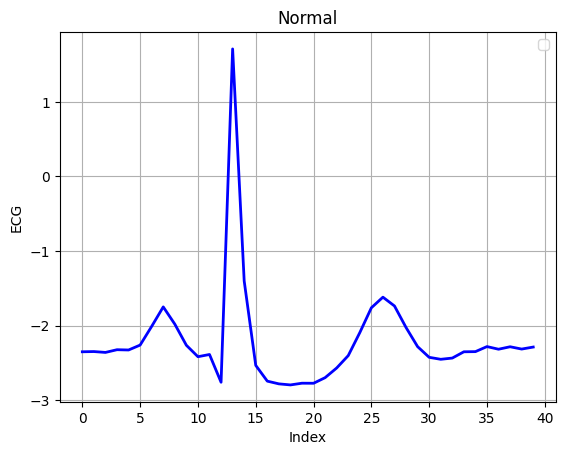

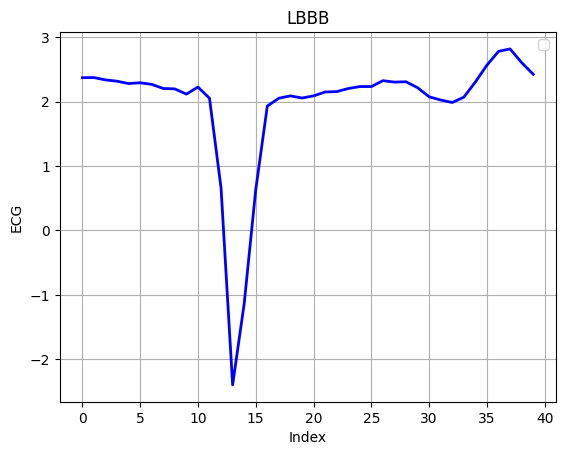

In [115]:
plot(train_app[0],"Normal")
plot(train_app[len(normal_train)],"LBBB")

## transforming data to statstical features

In [116]:
# Calculate statistics for each signal
statistics = [calculate_statistics(signal) for signal in train_app]
statistics_df = pd.DataFrame(statistics, columns=['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis'])

train_df = statistics_df

In [117]:
# Calculate statistics for each signal
statistics = [calculate_statistics(signal) for signal in test_app]
statistics_df = pd.DataFrame(statistics, columns=['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis'])

test_df = statistics_df

In [118]:
train_labels = [0] * len(normal_train) + [1] * len(lbbb_train)
test_labels = [0] * len(normal_test) + [1] * len(lbbb_test)

In [119]:
train_df['Label'] = train_labels
train_df

,Mean,Standard Deviation,Skewness,Kurtosis,Label
0,-2.209321,0.706894,4.245535,20.812578,0
1,-2.231773,0.720386,4.381279,21.784326,0
2,-2.204316,0.724514,4.218012,20.527704,0
3,-2.198512,0.716926,4.298561,21.345697,0
4,-2.152692,0.729966,4.281453,21.373684,0
...,...,...,...,...,...
594,1.305828,1.027181,-1.671910,4.148625,1
595,1.606541,0.970487,-2.507240,7.632638,1
596,1.472635,0.988884,-2.088275,6.111347,1
597,1.440582,0.972567,-2.109268,6.212387,1


In [120]:
print("duplicates = ", train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

duplicates =  199


In [121]:
print("Zeros = ", train_df[train_df['Label'] == 0].shape[0])
print("Ones = ", train_df[train_df['Label'] == 1].shape[0])

Zeros =  200
Ones =  200


In [122]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# `modeling`

In [123]:
#split data_train into x, y (target)
X_train = train_df.drop('Label', axis=1) #all columns except target
y_train = train_df['Label']  #target -> Label column a
X_test = test_df
y_test = test_labels


Evaluating model: KNN
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'n_neighbors': 11}
Train Accuracy: 98.75%
Test Accuracy: 98.15%
Confusion Matrix:


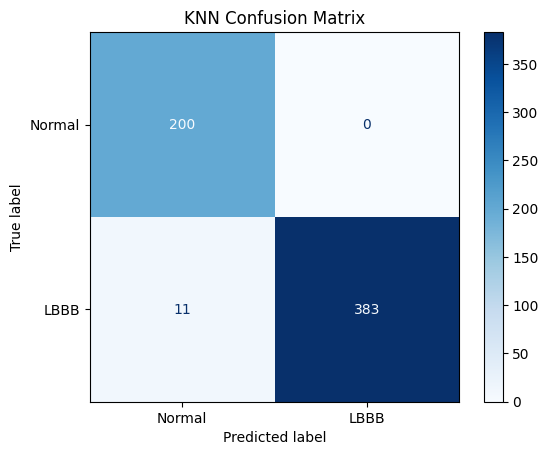

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97       200
        LBBB       1.00      0.97      0.99       394

    accuracy                           0.98       594
   macro avg       0.97      0.99      0.98       594
weighted avg       0.98      0.98      0.98       594

Feature Importance (Permutation):


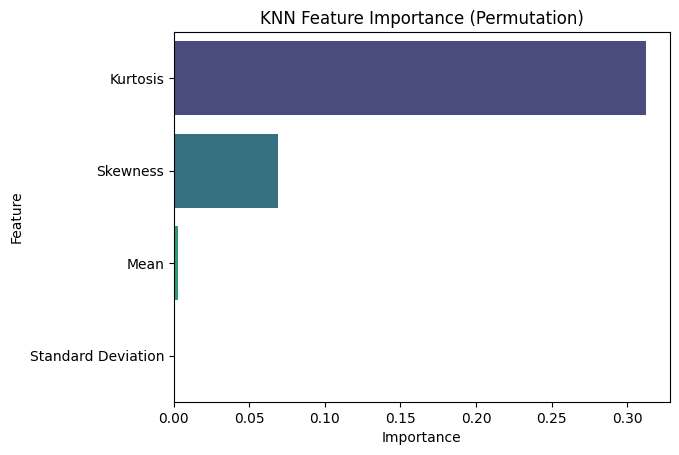

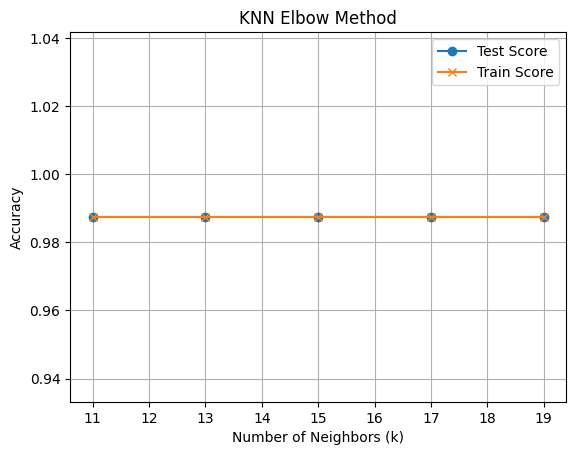


Evaluating model: SVM
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'C': 0.4, 'kernel': 'rbf'}
Train Accuracy: 99.25%
Test Accuracy: 90.91%
Confusion Matrix:


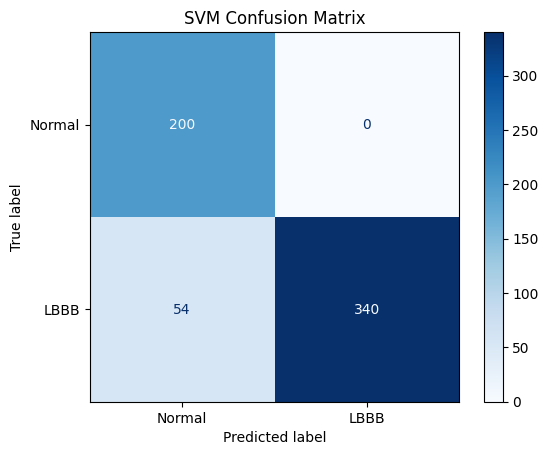

Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      1.00      0.88       200
        LBBB       1.00      0.86      0.93       394

    accuracy                           0.91       594
   macro avg       0.89      0.93      0.90       594
weighted avg       0.93      0.91      0.91       594

Feature Importance (Permutation):


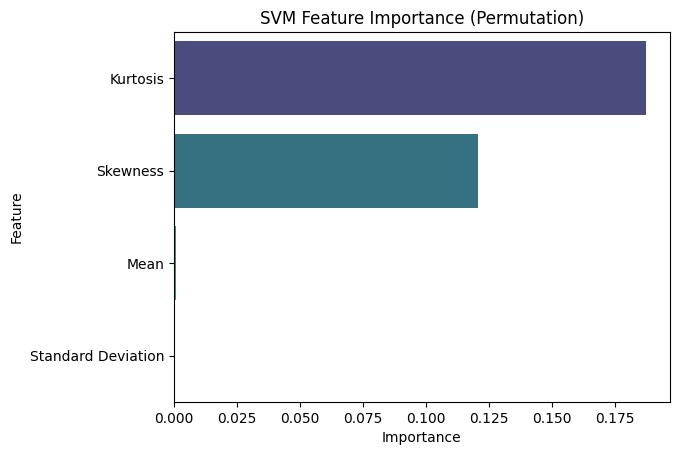

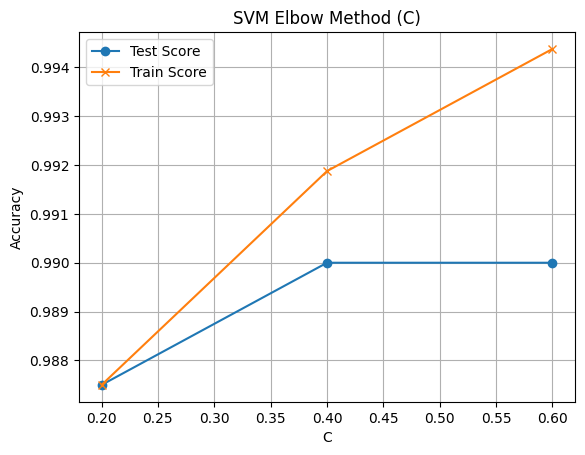

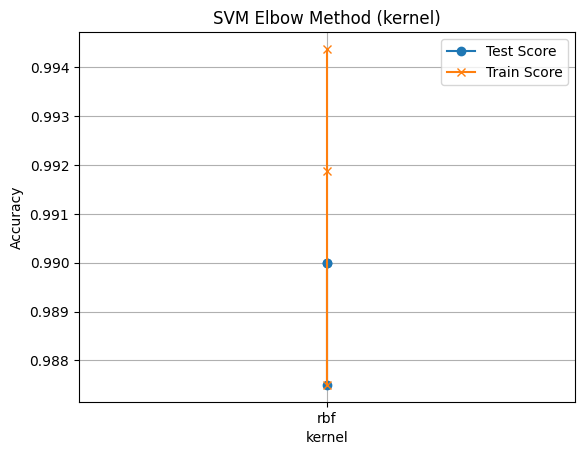


Evaluating model: Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'max_depth': 1, 'n_estimators': 1}
Train Accuracy: 99.50%
Test Accuracy: 87.21%
Confusion Matrix:


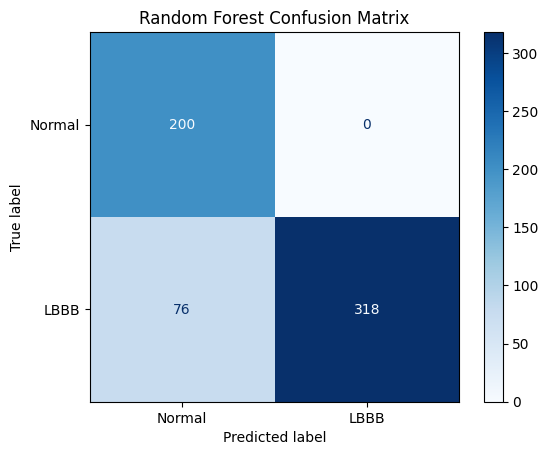

Classification Report:
              precision    recall  f1-score   support

      Normal       0.72      1.00      0.84       200
        LBBB       1.00      0.81      0.89       394

    accuracy                           0.87       594
   macro avg       0.86      0.90      0.87       594
weighted avg       0.91      0.87      0.88       594

Feature Importance:


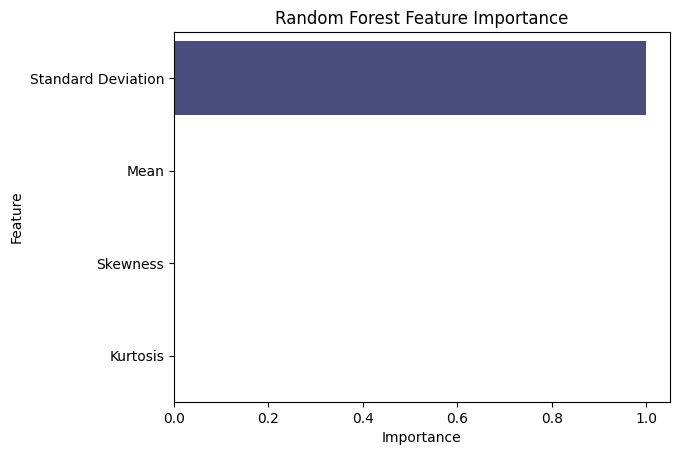

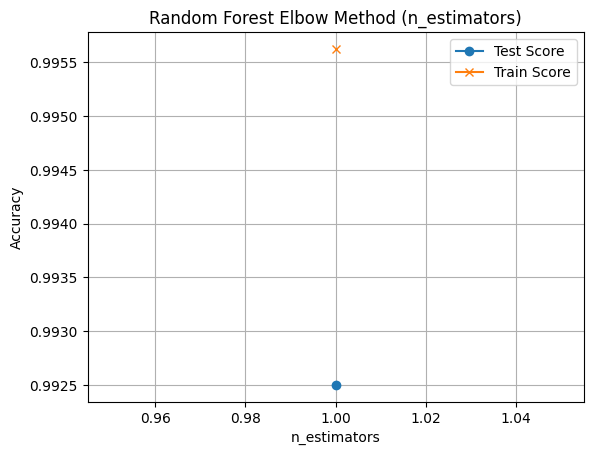

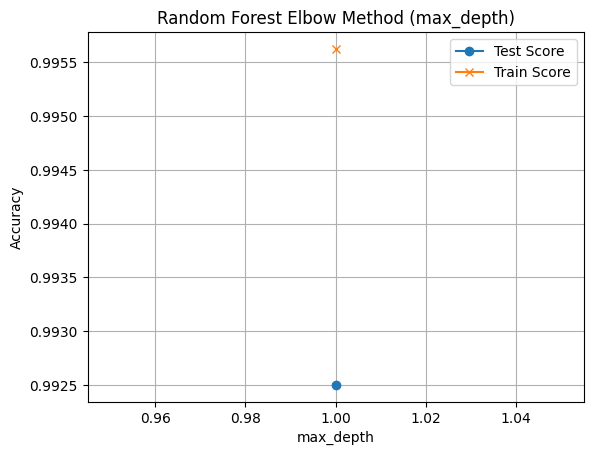

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Define models and their parameter grids
models = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "param_grid": {'n_neighbors': range(11, 21, 2)}
    },
    "SVM": {
        "model": SVC(),
        "param_grid": {'C': [0.2, 0.4, 0.6], 'kernel': ['rbf']}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "param_grid": {'n_estimators': [1], 'max_depth': [1]}
    }
}

for model_name, model_info in models.items():
    print(f"\nEvaluating model: {model_name}")
    
    # GridSearchCV
    grid_search = GridSearchCV(model_info["model"], model_info["param_grid"], cv=5, scoring='accuracy', verbose=1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    # Best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")
    
    # Train accuracy
    y_pred_train = best_model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    print(f"Train Accuracy: {accuracy_train * 100:.2f}%")
    
    # Test accuracy
    y_pred_test = best_model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    print("Confusion Matrix:")
    ConfusionMatrixDisplay(conf_matrix, display_labels=['Normal', 'LBBB']).plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=['Normal', 'LBBB']))
    
    # Feature importance for Random Forest
    if model_name == "Random Forest":
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        print("Feature Importance:")
        sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df, palette='viridis', legend=False)
        plt.title(f'{model_name} Feature Importance')
        plt.show()
    
    # Permutation importance for KNN and SVM
    if model_name in ["KNN", "SVM"]:
        result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': abs(result.importances_mean)
        }).sort_values(by='Importance', ascending=False)
        print("Feature Importance (Permutation):")
        sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df, palette='viridis', legend=False)
        plt.title(f'{model_name} Feature Importance (Permutation)')
        plt.show()
    
    # Elbow method plot for KNN
    if model_name == "KNN":
        results = pd.DataFrame(grid_search.cv_results_)
        plt.plot(results['param_n_neighbors'], results['mean_test_score'], marker='o', label='Test Score')
        plt.plot(results['param_n_neighbors'], results['mean_train_score'], marker='x', label='Train Score')
        plt.xlabel('Number of Neighbors (k)')
        plt.ylabel('Accuracy')
        plt.title(f'{model_name} Elbow Method')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Elbow method plot for SVM and Random Forest
    if model_name in ["SVM", "Random Forest"]:
        results = pd.DataFrame(grid_search.cv_results_)
        for param in model_info["param_grid"]:
            plt.plot(results[f'param_{param}'], results['mean_test_score'], marker='o', label='Test Score')
            plt.plot(results[f'param_{param}'], results['mean_train_score'], marker='x', label='Train Score')
            plt.xlabel(param)
            plt.ylabel('Accuracy')
            plt.title(f'{model_name} Elbow Method ({param})')
            plt.legend()
            plt.grid(True)
            plt.show()

In [125]:
import joblib
joblib.dump(model,'knn_model.joblib')

['knn_model.joblib']